<a href="https://colab.research.google.com/github/fabiobasson/Bi-Master/blob/main/geological_comparative30092021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importações 

In [2]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout

from os import getcwd
import zipfile
import shutil
import numpy as np
import glob
import random
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import plotly.express as px
import cv2 as cv

from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
print(tf.__version__)

2.6.0


In [3]:
# Instalar Tensorflow
#!pip install tensorflow==2.6.0

# Instalar Keras
!pip install keras --upgrade

In [4]:
# Caso precise, remover os diretorios

#!rm -rf geological_similarity andesite gneiss/ marble/ quartzite/ rhyolite/ schist/
#!rm -rf geological-image-similarity

# **Coleta de dados do Kaglle**

In [3]:
from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


# **###  Download dos dados / descompactando os dados**

In [4]:
#!kaggle datasets download fabiobasson/geologicalsimilarity
#! unzip -qq  geologicalsimilarity
!kaggle datasets download tanyadayanand/geological-image-similarity
! unzip -qq geological-image-similarity    

100% 33.6M/33.6M [00:01<00:00, 17.8MB/s]



# ** Criação da estrutura e leitura de diretórios **

In [5]:
andesite_dir = glob.glob('geological_similarity/andesite/*.jpg');gneiss_dir = glob.glob('geological_similarity/gneiss/*.jpg')
marble_dir= glob.glob('geological_similarity/marble/*.jpg');quartzite_dir = glob.glob('geological_similarity/quartzite/*.jpg')
rhyolite_dir = glob.glob('geological_similarity/rhyolite/*.jpg');
schist_dir = glob.glob('geological_similarity/schist/*.jpg')
print(len(andesite_dir));print(len(gneiss_dir)); print(len(marble_dir)); print(len(quartzite_dir));  print(len(quartzite_dir)); print(len(schist_dir))


5000
5000
4998
5000
5000
5000


# **Nomes das Classes**
# andesite = 0  # gneiss =1 # marbler = 2 # quartzite = 3 # rhyolite = 4  # schist = 5 


In [6]:
label = ['andesite','gneiss','marbler','quartzite','rhyolite','schist']

andesite_df=[];gneiss_df=[];marble_df=[];quartzite_df=[];rhyolite_df=[];schist_df=[]

for i in andesite_dir:
    andesite_df.append([i,label[0]])
for j in gneiss_dir:
   gneiss_df.append([j,label[1]])
for l in marble_dir:
    marble_df.append([l,label[2]])
for m in quartzite_dir:
    quartzite_df.append([m,label[3]])
for n in rhyolite_dir:
    rhyolite_df.append([n,label[4]])
for o in schist_dir:
    schist_df.append([o,label[5]])
   
df = andesite_df + gneiss_df + marble_df  + quartzite_df + rhyolite_df + schist_df
random.shuffle(df)
len(df)

29998

# **Criação do Dataframe**

In [7]:
data_df = pd.DataFrame(df,columns=['path','label'])
data_df

,path,label
0,geological_similarity/andesite/H9U1E.jpg,andesite
1,geological_similarity/gneiss/QPD5T.jpg,gneiss
2,geological_similarity/quartzite/POEM9.jpg,quartzite
3,geological_similarity/quartzite/TKXNP.jpg,quartzite
4,geological_similarity/quartzite/KQFI1.jpg,quartzite
...,...,...
29993,geological_similarity/rhyolite/09HC7.jpg,rhyolite
29994,geological_similarity/andesite/38A1P.jpg,andesite
29995,geological_similarity/quartzite/6GVCK.jpg,quartzite
29996,geological_similarity/schist/YCGAY.jpg,schist


#  Conhecendo os dados de imagem

In [8]:
from numpy import asarray
image = Image.open("geological_similarity/gneiss/0QTQE.jpg")
# Método asarray para realizar a conversão:
pixels= asarray(image)
# Verificando a faixa de valores entre 0 e 255:
print('Data Type: %s' % pixels.dtype)
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))

#Converte os valores inteiros em float para realizar a operação:
pixels = pixels.astype('float32')
# Normaliza a faixa de valores:
pixels /= pixels.max()
# Verificando a faixa de valores normalizada:
print('Data Type: %s' % pixels.dtype)
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))

Data Type: uint8
Min: 32.000, Max: 251.000
Data Type: float32
Min: 0.127, Max: 1.000


# **Limpeza de dados**
1 - Analisando os dados ausentes
2 - Descartando os dados ausentes
3 - Imputando dados
4 - Acrescentando colunas informativas

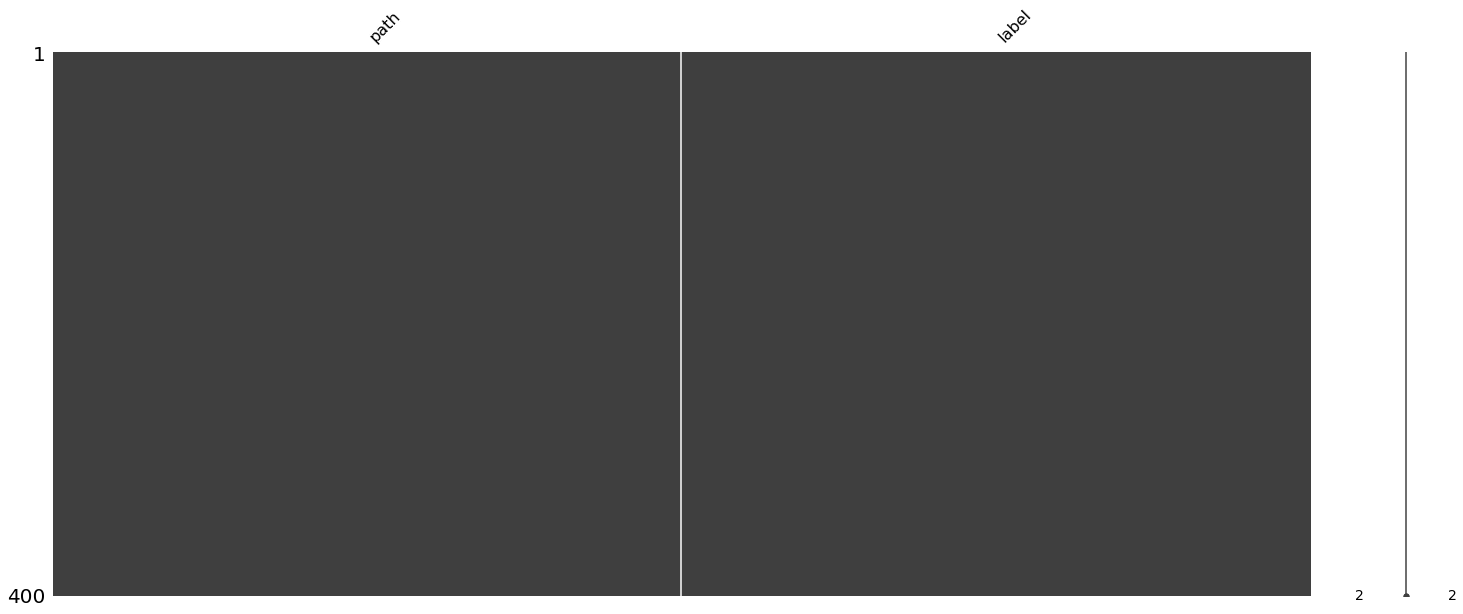

In [9]:
### 1 - Analisando os dados ausentes ###

import missingno as msno
ax = msno.matrix(data_df.sample(400))

In [12]:
#! pip install pandas-profiling==2.8.0
#from pandas_profiling import ProfileReport
#ProfileReport (data_df)

# **Separação das amostras**

In [8]:
X = data_df.drop(columns='label')
y = data_df.label

# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=42)

# **Explorando os dados**


# **Type: Data Augumentation**

## ** Esta função irá plotar as imagens num grid de 1 a 5 colunas **

In [9]:
IMG_SHAPE = 28
IMG_SHAPE_VGG16 = 32

BATCH_SIZE = 128

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [10]:
# Dados de Treino e Validação

datagen_train = ImageDataGenerator(rescale=1./255,
                            #featurewise_center =False ,
                            # samplewise_center =False ,
                            # featurewise_std_normalization =False ,
                            # samplewise_std_normalization =False ,
                            # zca_whitening =False ,
                            # zca_epsilon =1e -6 ,
                            # channel_shift_range =0. ,
                            # fill_mode = ’ nearest ’ ,
                            # cval =0. ,
                            rotation_range = 40,
                            width_shift_range = 0.2,
                            height_shift_range = 0.2,
                            #shear_range = 0.2,
                            #zoom_range = 0.2,
                            horizontal_flip = True,
                            vertical_flip = True,
                            validation_split=0.2)

train_generator = datagen_train.flow_from_dataframe(data_df,
                                               batch_size=BATCH_SIZE,
                                               x_col='path',
                                               y_col= 'label',
                                               shuffle=True,
                                               target_size=(IMG_SHAPE,IMG_SHAPE),
                                               class_mode='categorical',
                                               subset='training')

train_generator_VGG16 = datagen_train.flow_from_dataframe(data_df,
                                               batch_size=BATCH_SIZE,
                                               x_col='path',
                                               y_col= 'label',
                                               shuffle=True,
                                               target_size=(IMG_SHAPE_VGG16,IMG_SHAPE_VGG16),
                                               class_mode='categorical',
                                               subset='training')

datagen_val = ImageDataGenerator (rescale=1./255, 
                                 validation_split=0.2)


validation_generator = datagen_val.flow_from_dataframe(data_df,
                                                   batch_size=BATCH_SIZE,
                                                   x_col='path',
                                                   y_col='label',
                                                   shuffle=True,
                                                   target_size=(IMG_SHAPE,IMG_SHAPE),
                                                   class_mode='categorical',
                                                   subset='validation') 

validation_generator_VGG16 = datagen_val.flow_from_dataframe(data_df,
                                                   batch_size=BATCH_SIZE,
                                                   x_col='path',
                                                   y_col='label',
                                                   shuffle=True,
                                                   target_size=(IMG_SHAPE_VGG16,IMG_SHAPE_VGG16),
                                                   class_mode='categorical',
                                                   subset='validation')   

Found 23999 validated image filenames belonging to 6 classes.
Found 23999 validated image filenames belonging to 6 classes.
Found 5999 validated image filenames belonging to 6 classes.
Found 5999 validated image filenames belonging to 6 classes.


In [11]:
# Dados de Teste

datagen_test = ImageDataGenerator (rescale=1./255, 
                                 validation_split=0.2)


test_generator = datagen_test.flow_from_dataframe(data_df,
                                                   batch_size=BATCH_SIZE,
                                                   x_col='path',
                                                   y_col='label',
                                                   shuffle=False,
                                                   target_size=(IMG_SHAPE,IMG_SHAPE),
                                                   class_mode='categorical')
                                                   #subset='validation') 


test_generator_VGG16 = datagen_test.flow_from_dataframe(data_df,
                                                   batch_size=BATCH_SIZE,
                                                   x_col='path',
                                                   y_col='label',
                                                   shuffle=False,
                                                   target_size=(IMG_SHAPE_VGG16,IMG_SHAPE_VGG16),
                                                   class_mode='categorical')
                                                   #subset='validation') 

Found 29998 validated image filenames belonging to 6 classes.
Found 29998 validated image filenames belonging to 6 classes.


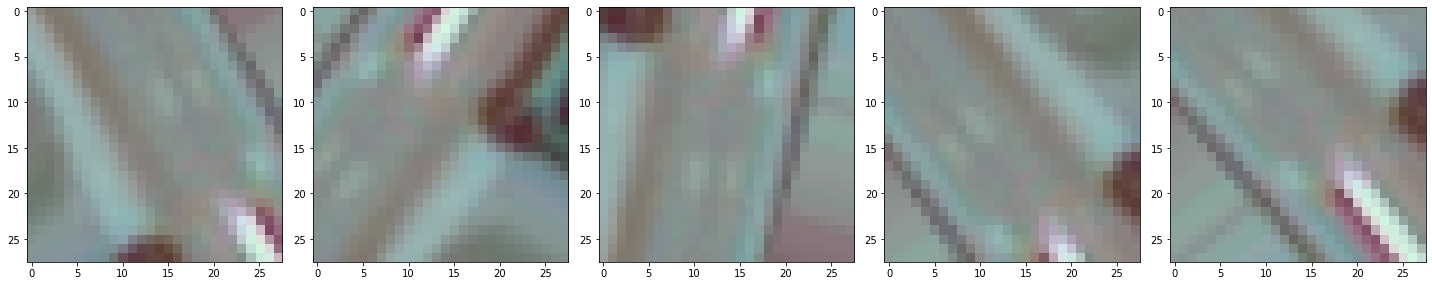

In [12]:
augmented_images = [train_generator[0][0][0] for i in range(5)]
plotImages(augmented_images)

# **Criando o Dataframe em dados de treino, validação e teste**

In [13]:
class_dict=train_generator.class_indices
labels= train_generator.labels
file_names= train_generator.filenames 

class_dict

{'andesite': 0,
 'gneiss': 1,
 'marbler': 2,
 'quartzite': 3,
 'rhyolite': 4,
 'schist': 5}

In [14]:
X_train, y_train = next(train_generator)
X_val, y_val = next(validation_generator)
X_test, y_test = next(test_generator)

X_trainVGG16, y_trainVGG16 = next(train_generator_VGG16)
X_valVGG16, y_valVGG16 = next(validation_generator_VGG16)
X_testVGG16, y_testVGG16 = next(test_generator_VGG16)

print(X_val.shape)
print(X_test)

(128, 28, 28, 3)
[[[[0.43137258 0.48235297 0.5058824 ]
   [0.2901961  0.34509805 0.35686275]
   [0.43921572 0.49411768 0.49803925]
   ...
   [0.41960788 0.45882356 0.454902  ]
   [0.42352945 0.46274513 0.45882356]
   [0.49411768 0.5294118  0.5176471 ]]

  [[0.4156863  0.47058827 0.48235297]
   [0.34117648 0.39607847 0.40784317]
   [0.45098042 0.49411768 0.5019608 ]
   ...
   [0.39607847 0.43529415 0.43137258]
   [0.45098042 0.4901961  0.48627454]
   [0.5058824  0.5411765  0.5294118 ]]

  [[0.41960788 0.47450984 0.48627454]
   [0.34901962 0.3921569  0.40000004]
   [0.5176471  0.5647059  0.5647059 ]
   ...
   [0.36862746 0.40784317 0.4039216 ]
   [0.45098042 0.49411768 0.4784314 ]
   [0.5254902  0.56078434 0.54901963]]

  ...

  [[0.41960788 0.427451   0.40784317]
   [0.4156863  0.42352945 0.4039216 ]
   [0.48627454 0.49411768 0.47450984]
   ...
   [0.427451   0.46274513 0.45098042]
   [0.49411768 0.5176471  0.50980395]
   [0.5019608  0.5254902  0.50980395]]

  [[0.4039216  0.40784317 0.

# **Criar o modelo**

In [16]:
num_classes = 6

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(28,28,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
   

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
   
])

# **Compilando o Modelo**

In [17]:
model.compile(optimizer = Adam(learning_rate=0.0001), 
               loss = 'categorical_crossentropy', 
               metrics =['accuracy'])
model.summary()  

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 16)          4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 16)          0

In [18]:
callbacks_list = [
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5,
                                         patience=4,
                                         verbose=0),
    tf.keras.callbacks.EarlyStopping(
        monitor="accuracy",
        patience=12,
        restore_best_weights=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_model.h5',
        monitor="val_accuracy",
        verbose=1,
        save_best_only=True,
        #save_weights_only=False,
        #mode='auto',
        #period=1,
    ),

]

# **Avaliar o modelo**

In [19]:
epochs=200
history = model.fit(X_train,y_train,
                               epochs=epochs,
                               verbose=1,
                               callbacks=callbacks_list, 
                               #validation_split=0.2,
                               #class_weight=class_weight_,
                               steps_per_epoch = 23999/256,
                               workers=4,
                               use_multiprocessing=True,
                               #validation_steps = 5999/512,
                               validation_data=(X_val,y_val))

Epoch 1/200
93/93 [==============================] - 33s 8ms/step - loss: 1.8031 - accuracy: 0.1543 - val_loss: 1.7881 - val_accuracy: 0.2031

Epoch 00001: val_accuracy improved from -inf to 0.20312, saving model to best_model.h5
Epoch 2/200
93/93 [==============================] - 0s 5ms/step - loss: 1.7172 - accuracy: 0.2872 - val_loss: 1.7531 - val_accuracy: 0.2812

Epoch 00002: val_accuracy improved from 0.20312 to 0.28125, saving model to best_model.h5
Epoch 3/200
93/93 [==============================] - 0s 5ms/step - loss: 1.6092 - accuracy: 0.3564 - val_loss: 1.6767 - val_accuracy: 0.4375

Epoch 00003: val_accuracy improved from 0.28125 to 0.43750, saving model to best_model.h5
Epoch 4/200
93/93 [==============================] - 0s 5ms/step - loss: 1.4773 - accuracy: 0.4734 - val_loss: 1.5194 - val_accuracy: 0.5703

Epoch 00004: val_accuracy improved from 0.43750 to 0.57031, saving model to best_model.h5
Epoch 5/200
93/93 [==============================] - 0s 5ms/step - loss: 1

**Deixe-nos representar graficamente a Precisão do treinamento versus perda para obter uma melhor compreensão do treinamento do modelo.**

Text(0.5, 1.0, 'Train - Accuracy')

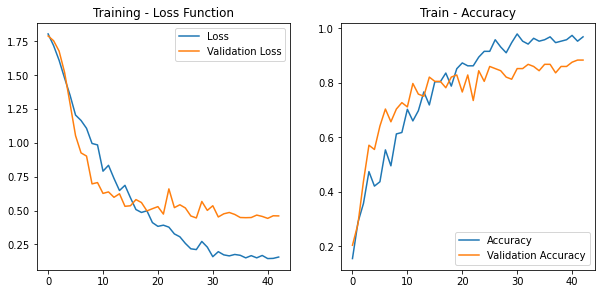

In [20]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')


# **Vamos traçar a precisão do treinamento e da validação, bem como a perda.** 

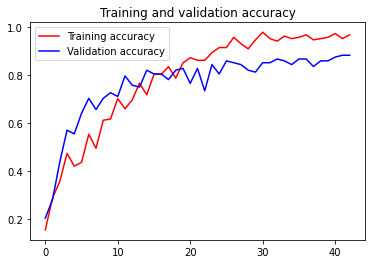

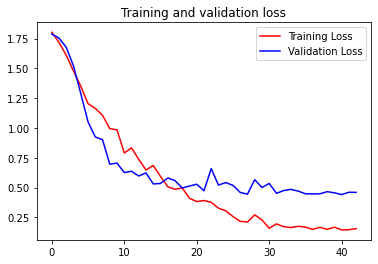

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [26]:
history2= model.history.history
px.line(history2,title = "Metrics Plot")

# **Otimizar o modelo**

# **Avaliar acurácia  do Modelo**

In [22]:
model = tf.keras.models.load_model("best_model.h5")

test_loss, test_acc= model.evaluate(X_test,y_test)
print("validation_accuracy: " + str(test_acc))

4/4 [==============================] - 0s 5ms/step - loss: 0.3805 - accuracy: 0.8203
validation_accuracy: 0.8203125


# **Listando as redes realmente disponíveis em seu Keras**

In [23]:
import tensorflow.keras.applications as app
print(dir(app))

['DenseNet121', 'DenseNet169', 'DenseNet201', 'EfficientNetB0', 'EfficientNetB1', 'EfficientNetB2', 'EfficientNetB3', 'EfficientNetB4', 'EfficientNetB5', 'EfficientNetB6', 'EfficientNetB7', 'InceptionResNetV2', 'InceptionV3', 'MobileNet', 'MobileNetV2', 'MobileNetV3Large', 'MobileNetV3Small', 'NASNetLarge', 'NASNetMobile', 'ResNet101', 'ResNet101V2', 'ResNet152', 'ResNet152V2', 'ResNet50', 'ResNet50V2', 'VGG16', 'VGG19', 'Xception', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_sys', 'densenet', 'efficientnet', 'imagenet_utils', 'inception_resnet_v2', 'inception_v3', 'mobilenet', 'mobilenet_v2', 'mobilenet_v3', 'nasnet', 'resnet', 'resnet50', 'resnet_v2', 'vgg16', 'vgg19', 'xception']


# **O Modelo pre treinado VGG16**

In [24]:
# Inicializar a CNN

classifier = VGG16(include_top=False,weights='imagenet',input_shape=(32,32,3))

58900480/58889256 [==============================] - 1s 0us/step


In [30]:
#inp = tf.keras.Input((28,28,3))

In [26]:
# marcar camadas como não treináveis
for layer in classifier.layers:
    layer.trainable = False

# adicionar novas camadas para classificação

flat1 = tf.keras.layers.Flatten()(classifier.layers[-1].output)
flat1 = Dense(1024, activation='relu', kernel_initializer='he_uniform')(flat1)
flat1 = tf.keras.layers.Dropout(0.5)(flat1)
output = Dense(6, activation='softmax')(flat1)

# definir o modelo
modelvgg16 = Model(inputs=classifier.inputs, outputs=output)

modelvgg16.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   

In [27]:
modelvgg16.compile(optimizer = Adam(learning_rate=0.0001), 
               loss = 'categorical_crossentropy', 
               metrics =['accuracy'])  

callbacksvgg16 = [
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5,
                                         patience=4,
                                         verbose=0),
    tf.keras.callbacks.EarlyStopping(
        monitor="accuracy",
        patience=12,
        restore_best_weights=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='feature_extraction.vgg16',
        save_best_only=True,
        monitor="val_accuracy",
    ),

]

In [28]:
epochs=200
historyvgg16 = modelvgg16.fit(X_trainVGG16,y_trainVGG16,
                    epochs=epochs,
                    verbose=1,
                    steps_per_epoch = 23999/256,
                    callbacks=callbacksvgg16,
                    validation_data=(X_valVGG16,y_valVGG16))
                    #validation_steps = 5999/64)

Epoch 1/200
93/93 [==============================] - 3s 21ms/step - loss: 1.8917 - accuracy: 0.3032 - val_loss: 1.3855 - val_accuracy: 0.6094
INFO:tensorflow:Assets written to: feature_extraction.vgg16/assets
Epoch 2/200
93/93 [==============================] - 1s 13ms/step - loss: 1.4342 - accuracy: 0.3989 - val_loss: 1.0415 - val_accuracy: 0.7188
INFO:tensorflow:Assets written to: feature_extraction.vgg16/assets
Epoch 3/200
93/93 [==============================] - 1s 13ms/step - loss: 1.2940 - accuracy: 0.5053 - val_loss: 0.8822 - val_accuracy: 0.7969
INFO:tensorflow:Assets written to: feature_extraction.vgg16/assets
Epoch 4/200
93/93 [==============================] - 1s 13ms/step - loss: 1.1113 - accuracy: 0.5585 - val_loss: 0.7763 - val_accuracy: 0.7969
Epoch 5/200
93/93 [==============================] - 1s 13ms/step - loss: 1.0096 - accuracy: 0.6170 - val_loss: 0.6915 - val_accuracy: 0.8047
INFO:tensorflow:Assets written to: feature_extraction.vgg16/assets
Epoch 6/200
93/93 [===

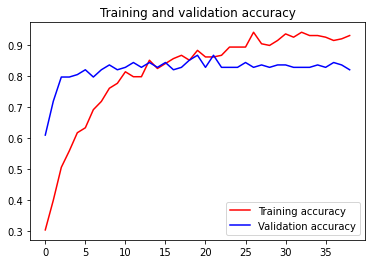

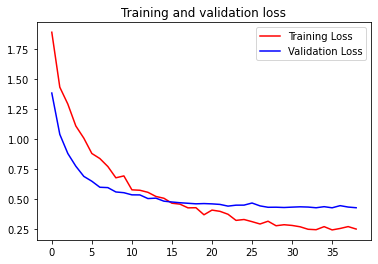

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = historyvgg16.history['accuracy']
val_acc = historyvgg16.history['val_accuracy']
loss = historyvgg16.history['loss']
val_loss = historyvgg16.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [30]:
modelvgg16 = tf.keras.models.load_model("feature_extraction.vgg16")

test_lossvgg16, test_accvgg16= modelvgg16.evaluate(X_testVGG16,y_testVGG16)
print("validation_accuracy: " + str(test_accvgg16))

4/4 [==============================] - 0s 17ms/step - loss: 0.5567 - accuracy: 0.8203
validation_accuracy: 0.8203125


# **Comparandos os modelos**

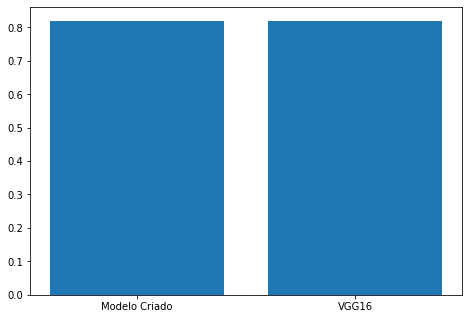

In [31]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
acc = [test_acc,test_accvgg16]
model = ['Modelo Criado','VGG16']
#model = ['Modelo Criado','VGG16','InceptionV3','EfficientNetB0','EfficientNetB7']
ax.bar(model,acc)
plt.show()

# **Realizar a Predição para as 6 classes**

In [32]:
plt.figure()
plt.imshow(X_train[i])
plt.colorbar()
plt.grid(False)
image_shape = plt.show()

IndexError: ignored

<Figure size 432x288 with 0 Axes>

In [118]:
class_dict=train_generator.class_indices
labels= train_generator.labels
file_names= train_generator.filenames 

class_dict

{'andesite': 0,
 'gneiss': 1,
 'marbler': 2,
 'quartzite': 3,
 'rhyolite': 4,
 'schist': 5}

In [78]:
y_train[i]

array([0., 0., 0., 1., 0., 0.], dtype=float32)

Escalaremos esses valores no intervalo de 0 e 1 antes antes de alimentar o modelo da rede neural. Para fazer isso, dividimos os valores por 255. É importante que o conjunto de treinamento e o conjunto de teste podem ser pré-processados do mesmo modo:

In [45]:
X_train = X_train /255
X_test = X_test /255

In [1]:
class_names = ['andesite','gneiss','marbler','quartzite','rhyolite','schist']
#class_names = [0,1,2,3,4,5]

plt.figure(figsize=(10, 10))
for i in range(36):
    plt.subplot(6, 6, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i])
    label_index = y_train[i]
    #plt.title(class_dict)
plt.show()


NameError: ignored

In [97]:
# Codigo do Dr.(o)professor Leonardo Forero

def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(label[predicted_label],
                                100*np.max(predictions_array),
                                label[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

NameError: ignored

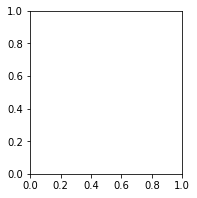

In [98]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, y_test, X_test)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  y_test)
plt.show()

In [86]:
predictions = model.predict(X_test)
print("Prediction_accuracy: " + str(predictions))

AttributeError: ignored

In [ ]:
predictions[0] # primeira predição

In [ ]:
np.argmax(predictions[0])

In [ ]:
predictions = np.argmax(predictions)
predictions

In [ ]:
y_test[0]

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(X_test,str(predictions))